In [25]:
%matplotlib inline
%pylab inline

from functools import partial

import menpo.io as mio
from menpo.feature import imgfeature, fast_dsift

from menpo.landmark import labeller, ibug_face_68_trimesh
from menpo.visualize import visualize_images, print_dynamic, plot_graph

from menpofit.result import compute_normalise_point_to_point_error
from menpofit.aam import (
    HolisticAAM, LucasKanadeAAMFitter, 
    holistic_sampling_from_scale,  holistic_sampling_from_step)
from menpofit.aam.algorithm.lk_alabort_arxiv2015 import (
    SSDForwardNewtonSimultaneous,
    SSDForwardNewtonAlternated,
    SSDInverseNewtonSimultaneous,
    SSDInverseNewtonAlternated,
    SSDAsymmetricNewtonSimultaneous,
    SSDAsymmetricNewtonAlternated,
    SSDBidirectionalNewtonSimultaneousCombined,
    SSDBidirectionalNewtonSimultaneous,
    SSDBidirectionalNewtonAlternated,
    SSDBidirectionalNewtonAlternatedCombined)
from menpofit.visualize import visualize_fitting_result, plot_ced

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [7]:
@imgfeature
def fast_dsift2(image):
    if image.n_channels == 3:
        image = image.as_greyscale(mode='average')
    return fast_dsift(image)

## Load AAM

In [ ]:
aam = mio.import_pickle('/Users/joan/PhD/Results/alabort_aam_2015/aam.pkl.gz')

## Load test data

In [10]:
test_images = []
for i in mio.import_images('/Users/joan/PhD/DataBases/faces/lfpw/testset/', 
                           verbose=True, max_images=None):    
    i.rescale_landmarks_to_diagonal_range(200)
    i = i.crop_to_landmarks_proportion(0.5)
    labeller(i, 'PTS', ibug_face_68_trimesh)
    if i.n_channels == 3:
        test_images.append(i)

Importing assets: [==========] 100% (224/224) - done.                           


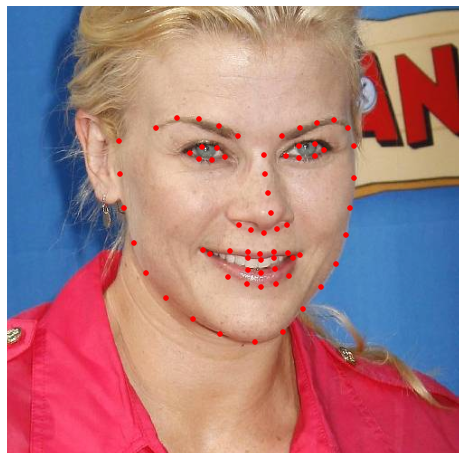

In [11]:
visualize_images(test_images)

## Fit Active Appearance Models

In [16]:
n_shape = [3, 12]
n_appearance = 0.75
max_iters = [12, 8]
scale = 0.25
noise_percentage = 0.04

In [ ]:
sampling_step_1, sampling_mask_1 = holistic_sampling_from_scale(aam.appearance_models[0].mean(), 
                                                                scale=np.minimum(2 * scale, 1))

sampling_mask_1.view()

In [ ]:
sampling_step_2, sampling_mask_2 = holistic_sampling_from_scale(aam.appearance_models[1].mean(), scale=scale)

sampling_mask_2.view()

In [ ]:
sampling_step = [sampling_step_1, sampling_step_2]

#### AAM Fitter

In [17]:
algorithms = [SSDForwardNewtonSimultaneous,
              SSDForwardNewtonAlternated,
              SSDInverseNewtonSimultaneous,
              SSDInverseNewtonAlternated,
              SSDAsymmetricNewtonSimultaneous,
              SSDAsymmetricNewtonAlternated,
              SSDBidirectionalNewtonSimultaneousCombined,
              SSDBidirectionalNewtonSimultaneous,
              SSDBidirectionalNewtonAlternatedCombined
              SSDBidirectionalNewtonAlternated]

fitters = []
for algorithm in algorithms:

    fitter = LucasKanadeAAMFitter(
        aam, 
        lk_algorithm_cls=partial(algorithm),
        n_shape=n_shape, 
        n_appearance=n_appearance,
        sampling=sampling_step)
    
    fitters.append(fitter)

In [ ]:
am_0 = fitter.aam.appearance_models[0]
am_1 = fitter.aam.appearance_models[1]

print '1st scale -> \tvariance:', am_0.variance_ratio(), '\tcomponents:', am_0.n_active_components
print '2nd scale -> \tvariance:', am_1.variance_ratio(), '\tcomponents:', am_1.n_active_components

In [ ]:
n_fitters = len(fitters)
legend_entries = ['ini', 
                  'f_s', 'f_a', 
                  'i_s', 'i_a', 
                  'a_s', 'a_a', 
                  'b_s', 'b_s_c', 'b_a', 'b_a_c']

#### Fitting loop

In [46]:
fitters_results = []
for j, i in enumerate(test_images):
    
    np.random.seed(j)
    
    gt_s = i.landmarks['ibug_face_68_trimesh'].lms
    s = fitters[0].noisy_shape_from_shape(gt_s, noise_percentage=noise_percentage)

    for fitter in fitters:
        
        fr = fitter.fit_from_shape(i, s, gt_shape=gt_s, max_iters=max_iters) 
        fr.downscale = 0.5
        fitters_results.append(fr)
    
        print_dynamic(
            'Image: {} - Initial error: {} - Final error: {}'
            .format(j, fr.initial_error(), fr.final_error()))

## Visualize Results

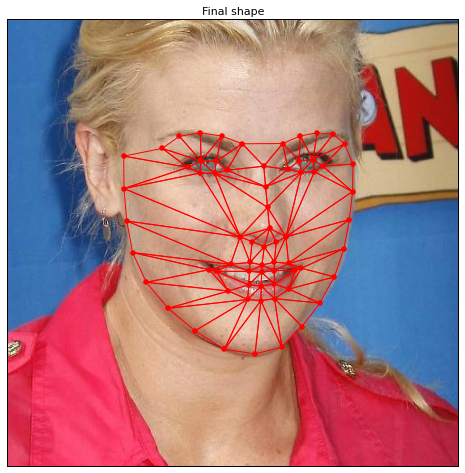

In [47]:
visualize_fitting_result(fitters_results[2::n_fitters])

In [48]:
errors = [[]]
for fr in fitters_results[::n_fitters]:
    error = compute_normalise_point_to_point_error(fr.initial_shape.points[17:, :], 
                                                   fr.gt_shape.points[17:, :],
                                                   norm_shape=fr.gt_shape.points)
    errors[0].append(error)

for j in range(n_fitters):
    errors_j = []
    for fr in fitters_results[j::n_fitters]:
        error = compute_normalise_point_to_point_error(fr.final_shape.points[17:, :], 
                                                       fr.gt_shape.points[17:, :],
                                                       norm_shape=fr.gt_shape.points)
        errors_j.append(error)
    errors.append(errors_j)

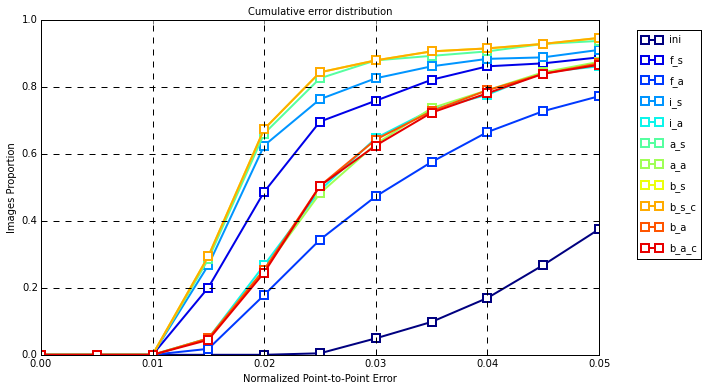

In [49]:
plot_ced(errors, legend_entries=legend_entries)

In [50]:
for j, e in enumerate(errors):
    print legend_entries[j], '\tmean:', np.mean(e), '\tstd:', np.std(e), '\tmedian:', np.median(e)

ini 	mean: 0.0638379926257 	std: 0.0321491263359 	median: 0.0570493893668
f_s 	mean: 0.0309301078038 	std: 0.0342807936527 	median: 0.0201942176868
f_a 	mean: 0.0418759810847 	std: 0.0343144866203 	median: 0.0313812596266
i_s 	mean: 0.027350290782 	std: 0.0311077955374 	median: 0.0180709936938
i_a 	mean: 0.0353707697111 	std: 0.0321678176476 	median: 0.0254392027058
a_s 	mean: 0.025242335767 	std: 0.0299772028779 	median: 0.0176088059388
a_a 	mean: 0.0355144254868 	std: 0.0323589494261 	median: 0.0253868570985
b_s 	mean: 0.0247237990292 	std: 0.0297895145719 	median: 0.0172356436396
b_s_c 	mean: 0.0247265230252 	std: 0.0297887461176 	median: 0.0172245655752
b_a 	mean: 0.0352475253093 	std: 0.0322835658458 	median: 0.0245652094823
b_a_c 	mean: 0.0357155362679 	std: 0.0323498829928 	median: 0.0249062347994


In [52]:
mean_errors = []
median_errors = []
for j in range(n_fitters):
    errors = np.asarray([fr.errors() for fr in fitters_results[j::n_fitters]])
    mean_errors.append(np.mean(errors, axis=0))
    median_errors.append(np.median(errors, axis=0))

TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [56]:
errors

array([ [0.077088209079190645, 0.065303588909041338, 0.055945768980278816, 0.048594159235382545, 0.042898580018058595, 0.038943203406003865, 0.036238552266538167, 0.034417358043679284, 0.033174893977140969, 0.032342992742486226, 0.031757667995116687, 0.03175766799511795, 0.023088275323238251, 0.021199562578729098, 0.02070569476896068, 0.020552427894419783, 0.020498199766358114, 0.020480023928625787, 0.020474347368611267, 0.020472719164637082, 0.020472300879789053, 0.020472223083247115],
       [0.089305066614382755, 0.079236910407647979, 0.071685409712381853, 0.06704161542052757, 0.064834281681429934, 0.063840243728456772, 0.063389745504105685, 0.063175342642302554, 0.063073405976761102, 0.06302482644643212, 0.063002260508211533, 0.063002260508213517, 0.059362744679090695, 0.057162440235837331, 0.055989710658318363, 0.055387599377338732, 0.055081233331252498, 0.054923079559363645, 0.054836863500544057, 0.054787612141846652, 0.054758457221162925, 0.054740659784662068],
       [0.0343348

In [ ]:
plot_graph(np.arange(0, len(mean_errors[0])), 
           mean_errors, 
           y_axis_limits=(0.015, 0.065),
           legend_entries=legend_entries[1:])

In [ ]:
plot_graph(np.arange(0, len(median_errors[0])), 
           median_errors, 
           y_axis_limits=(0.015, 0.065),
           legend_entries=legend_entries[1:])

In [45]:
%timeit fr = fitter_1.fit_from_shape(i, s, gt_shape=gt_s, max_iters=20) 
%timeit fr = fitter_2.fit_from_shape(i, s, gt_shape=gt_s, max_iters=20) 
%timeit fr = fitter_3.fit_from_shape(i, s, gt_shape=gt_s, max_iters=20) 
%timeit fr = fitter_4.fit_from_shape(i, s, gt_shape=gt_s, max_iters=20) 
%timeit fr = fitter_5.fit_from_shape(i, s, gt_shape=gt_s, max_iters=20) 
%timeit fr = fitter_6.fit_from_shape(i, s, gt_shape=gt_s, max_iters=20) 

1 loops, best of 3: 342 ms per loop
1 loops, best of 3: 311 ms per loop
1 loops, best of 3: 340 ms per loop
1 loops, best of 3: 319 ms per loop
1 loops, best of 3: 374 ms per loop
1 loops, best of 3: 355 ms per loop


In [20]:
# import line_profiler
# import IPython

# ip = IPython.get_ipython()
# ip.define_magic('lprun', line_profiler.magic_lprun)

In [21]:
# %lprun -f ProjectOutAsymmetricGaussNewton._solve fitter_3.fit_from_shape(i, s, gt_shape=gt_s, max_iters=2) 